# Лабораторная работа №4
Численно решить уравнение Пуассона в прямоугольнике с использованием существующих прямых решателей (spsolve) систем линейных уравнений.
## Вариант №11
Найти решение уравнения Пуассона с граничными условиями Неймана по оси $x$ и периодическими условиями вдоль оси $y$:
\begin{equation*}
\begin{cases}
    \Delta u = (9x-10)e^{-5x}\sin{4y}, \ \ 0 < x < 1,\ \ 0 < y < \pi \\
    \displaystyle u_x(0, y) = \sin{4y},\ \ u_x(1, y) = -\frac{4}{e^5}\sin{4y} \\
    u(x, y + \pi) = u(x, y) 
\end{cases}
\end{equation*}

Точное решение:
$$ u_0(x, y) = xe^{-5x}\sin{4y} $$

Обозначим $\displaystyle \varphi_L(y) = -\sin{4y}, \ \ \varphi_R(y) = -\frac{4}{e^5}\sin{4y}, \ \ f(x, y) = -(9x-10)e^{-5x}\sin{4y}$

Перейдем к разностной схеме:

$ \displaystyle (Lu)_{i,j} = [i > 1] \frac{u_{i,j} - u_{i-1, j}}{h_x^2} + [i < n_x] \frac{u_{i,j} - u_{i+1,j}}{h_x^2} + [j > 1] \frac{u_{i,j} - u_{i, j-1}}{h_y^2} + [j < n_y] \frac{u_{i,j} - u_{i, j+1}}{h_y^2} +$

$\displaystyle \ \ \ \ \ \ \ \ \ \ \ \ \ \ + [j = 1]\frac{u_{i, j} - u_{i, n_y}}{h_y^2} + [j = n_y]\frac{u_{i,j} - u_{i, 1}}{h_y^2}$

$\displaystyle (F)_{i,j} = f_{i,j} + [i = 1]\frac{\varphi_{Lj}}{h_x} + [i = x_n]\frac{\varphi_{Rj}}{h_x}$

Импортируем необходимые библиотеки

In [19]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import gridspec
from scipy import sparse as sp
from scipy.sparse import linalg as LA
import time
%matplotlib inline

Зададим функции для получения разреженной матрицы оператора:

In [20]:
def getL_csr(n_x, n_y, h_x, h_y):
    # двумерный массив элементы которого равны  индексу ячейки
    k = np.arange(n_x * n_y, dtype=int).reshape((n_x, n_y)) 

    I, J = np.meshgrid(np.arange(n_x), np.arange(n_y))
    I, J = I.flatten(), J.flatten()

    iC = k[I, J].flatten() # есть соседи снизу и сверху
    iB = k[I, (J - 1) % n_y].flatten() # соседи снизу
    iT = k[I, (J + 1) % n_y].flatten() # соседи сверху

    iHR = k[:-1, :].flatten() # есть сосед справа
    iR  = k[1: , :].flatten() # сосед справа

    iHL = k[1:  , :].flatten() # есть сосед слева
    iL  = k[:-1 , :].flatten() # сосед слева

    R1, C1, V1 = iC, iC, np.full(iC.size, +2.0/h_y**2)
    R2, C2, V2 = iC, iB, np.full(iC.size, -1.0/h_y**2)
    R3, C3, V3 = iC, iT, np.full(iC.size, -1.0/h_y**2)

    R4, C4, V4 = iHL, iHL, np.full(iHR.size, +1.0/h_x**2)
    R5, C5, V5 = iHL, iL,  np.full(iHL.size, -1.0/h_x**2)

    R6, C6, V6 = iHR, iHR, np.full(iHR.size, +1.0/h_x**2)
    R7, C7, V7 = iHR, iR,  np.full(iHR.size, -1.0/h_x**2)

    row = np.concatenate((R1, R2, R3, R4, R5, R6, R7))
    col = np.concatenate((C1, C2, C3, C4, C5, C6, C7))
    val = np.concatenate((V1, V2, V3, V4, V5, V6, V7))

    return sp.csr_matrix((val, (row, col)))

def getL_lil(n_x, n_y, h_x, h_y):
    k = np.arange(n_x * n_y, dtype=int).reshape((n_x, n_y)) 

    L = sp.lil_matrix((n_x * n_y, n_x * n_y))

    for i in range(n_x):
        for j in range(n_y):
            if i == 0:
                L[k[i,j], k[i, j]] += 1.0/ h_x ** 2
                L[k[i, j], k[i + 1, j]] = -1.0/ h_x ** 2
            elif i == n_x - 1:
                L[k[i, j], k[i, j]] += 1.0 / h_x ** 2
                L[k[i, j], k[i - 1, j]] =  -1.0 / h_x ** 2
            else:
                L[k[i, j], k[i, j]] += 2.0 / h_x ** 2
                L[k[i, j], k[i - 1,j]] = -1.0 / h_x ** 2
                L[k[i, j], k[i + 1, j]] = -1.0 / h_x ** 2
            
            L[k[i, j], k[i, j]] += 2.0 / h_y ** 2
            L[k[i,j], k[i, (j - 1) % n_y]] = -1.0 / h_y ** 2
            L[k[i, j], k[i, (j + 1) % n_y]] = -1.0 / h_y ** 2
        
    return L.tocsr()

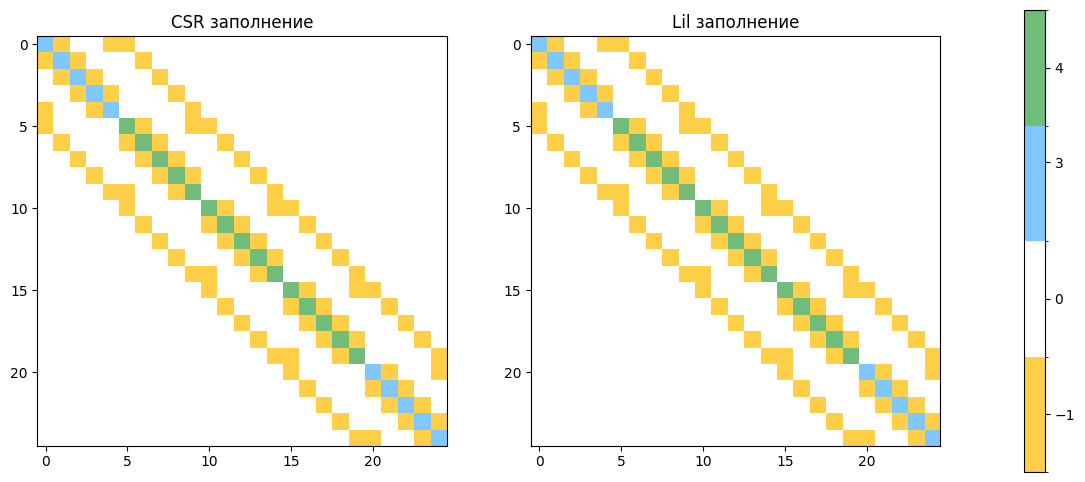

In [21]:
L_csr = getL_csr(5, 5, 1, 1)
L_lil = getL_lil(5, 5, 1, 1)

colors = ['#FFCF48', '#ffffff', '#7FC7FF', '#71BC78']
custom_cmap = ListedColormap(colors)
boundaries = [-1.05, -0.95, 0.95, 3.95, 4.05]
ticks = [-1, 0, 3, 4, 5]
norm = BoundaryNorm(boundaries, custom_cmap.N, extend='neither')

fig = plt.figure(figsize=(13, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.3)
ax1 = fig.add_subplot(gs[0])
ax1.set_title("CSR заполнение")
ax2 = fig.add_subplot(gs[1])
ax2.set_title("Lil заполнение")
cb_ax = fig.add_subplot(gs[2]) 
im1, im2 = ax1.imshow(L_csr.toarray(), cmap=custom_cmap, norm=norm), \
           ax2.imshow(L_lil.toarray(), cmap=custom_cmap, norm=norm)
cbar = fig.colorbar(im2, cb_ax, boundaries=boundaries, ticks=ticks)
cbar.ax.tick_params(labelsize=10) 
plt.show()

Мне было немного скучно, и я решил скорость заполнения замерить.

In [22]:
times_csr = []
times_lil = []
sizes = [5, 10, 20, 50, 100, 500, 1000]

for i in sizes:
    start_time = time.time()
    getL_csr(i, i, 1, 1)
    end_time = time.time()
    times_csr.append(end_time - start_time)

    start_time = time.time()
    getL_lil(i, i, 1, 1)
    end_time = time.time()
    times_lil.append(end_time - start_time)

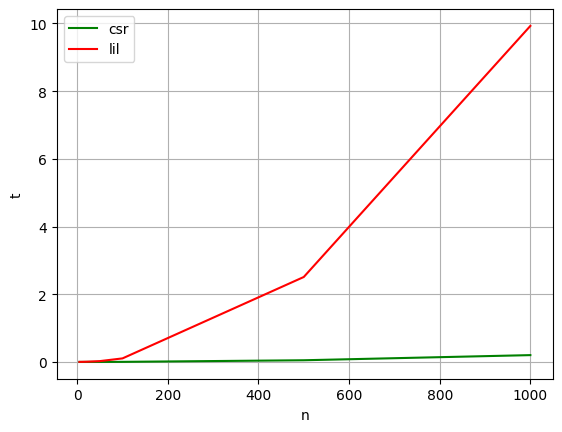

In [23]:
plt.plot(sizes, times_csr, color='green', label='csr')
plt.plot(sizes, times_lil, color='red', label='lil')
plt.ylabel('t')
plt.xlabel('n')
plt.legend()
plt.grid(True)
plt.show()

Заполнение через csr матрицу оказалось в разы эффективнее.

Пора, так сказать, возвращаться к теме.
Введем функции из задачи:

In [24]:
def analitical(x, y):
    return x * np.exp(-5 * x) * np.sin(4 * y)

def f(x, y): 
    return -(9 * x - 10) * np.exp(-5 * x) * np.sin(4 * y)

def phi_L(y):
    return -np.sin(4 * y)

def phi_R(y):
    return -4 * np.exp(-5) * np.sin(4 * y)

def RHS(X, Y, h_x, h_y):
    res = f(X, Y)
    res[0, :] += phi_L(Y[0, :]) / h_x
    res[-1,:] += phi_R(Y[-1,:]) / h_x
    return res - res.mean()

Пора решать!

In [25]:
h_0 = 0.01
l_x, l_y = 1, np.pi
n_x, n_y = int(np.round(l_x / h_0)), int(np.round(l_y / h_0))
h_x, h_y = l_x / n_x, l_y / n_y
x = np.linspace(h_x / 2, l_x - h_x / 2, n_x)
y = np.linspace(h_y / 2, l_y - h_y / 2, n_y)
X, Y = np.meshgrid(x, y, indexing='ij')

L = getL_csr(n_x, n_y, h_x, h_y)
F = RHS(X, Y, h_x, h_y).flatten()

In [26]:
start_time = time.time()
u_sp = LA.spsolve(L, F).reshape((n_x, n_y))
u_sp -= u_sp.mean()
end_time = time.time()
time_sp = end_time - start_time

In [27]:
start_time = time.time()
u_bi, _ = LA.bicgstab(L, F)
u_bi = u_bi.reshape((n_x, n_y))
u_bi -= u_bi.mean()
end_time = time.time()
time_bi = end_time - start_time

In [28]:
start_time = time.time()
u_cg, _ = LA.cg(L, F)
u_cg = u_cg.reshape((n_x, n_y))
u_cg -= u_cg.mean()
end_time = time.time()
time_cg = end_time - start_time

In [29]:
start_time = time.time()
u_gm, _ = LA.gmres(L, F)
u_gm = u_gm.reshape((n_x, n_y))
u_gm -= u_gm.mean()
end_time = time.time()
time_gm = end_time - start_time

In [30]:
start_time = time.time()
u_gc, _ = LA.gcrotmk(L, F, atol=0.0)
u_gc = u_gc.reshape((n_x, n_y))
u_gc -= u_gc.mean()
end_time = time.time()
time_gc = end_time - start_time

In [31]:
start_time = time.time()
u_qm, _ = LA.qmr(L, F, atol=0.0)
u_qm = u_qm.reshape((n_x, n_y))
u_qm -= u_qm.mean()
end_time = time.time()
time_qm = end_time - start_time

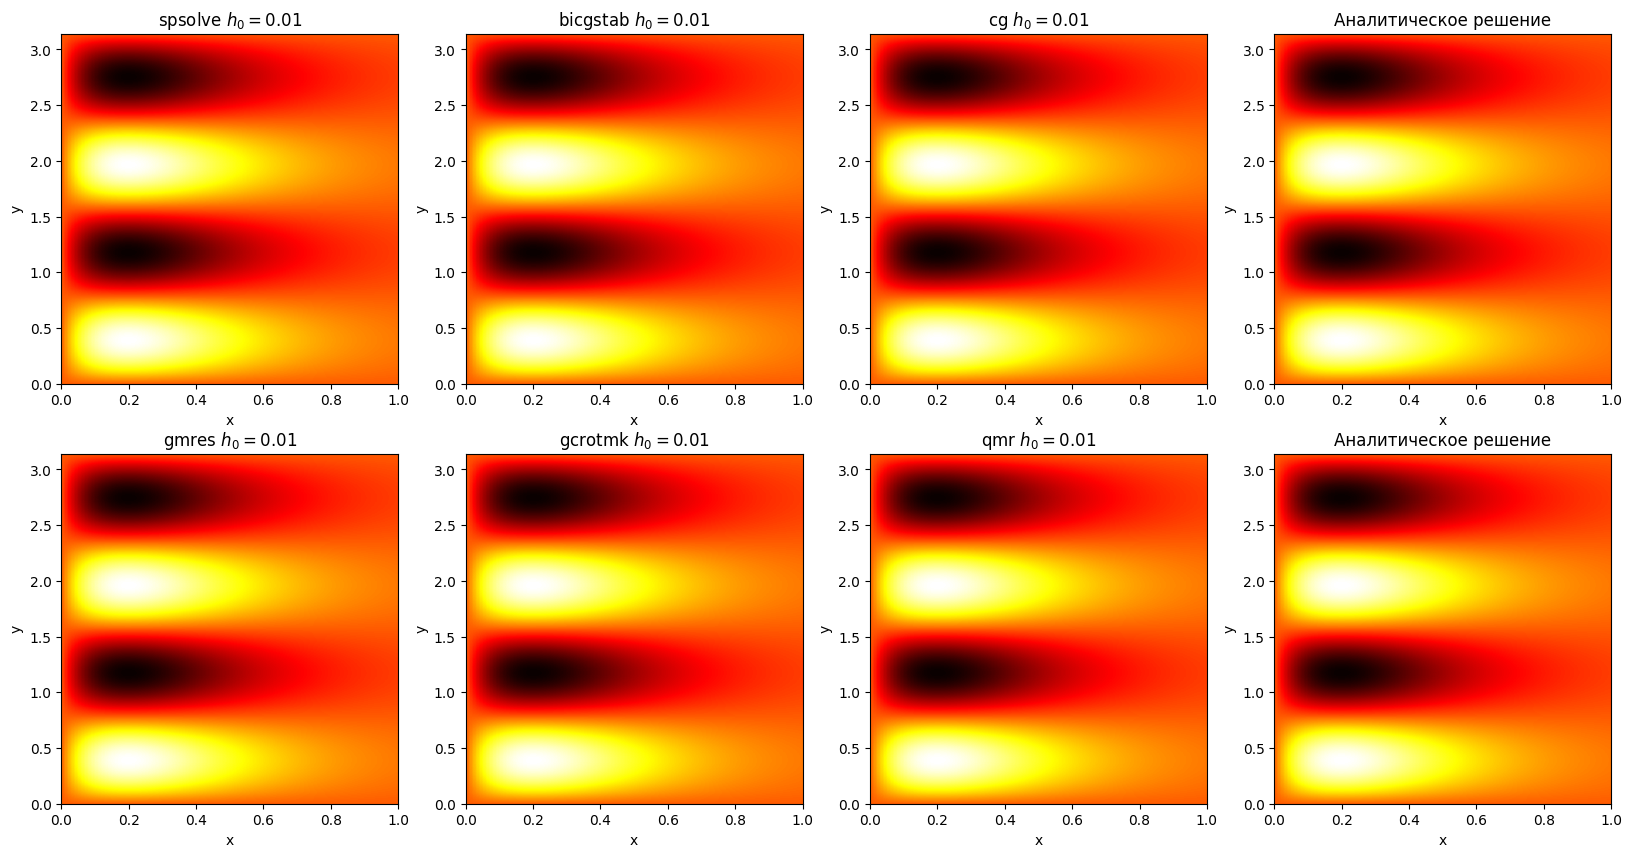

In [32]:
fig = plt.figure(figsize=(20, 10))
vmin = analitical(X, Y).min()
vmax = analitical(X, Y).max()

ax1 = fig.add_subplot(241)
im1 = ax1.imshow(u_sp.T, origin='lower', cmap='hot', extent=(0, l_x, 0, l_y), aspect='auto', vmin=vmin, vmax=vmax)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title(f'spsolve $h_0 = ${h_0}')

ax2 = fig.add_subplot(242)
im2 = ax2.imshow(u_bi.T, origin='lower', cmap='hot', extent=(0, l_x, 0, l_y), aspect='auto', vmin=vmin, vmax=vmax)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title(f'bicgstab $h_0 = ${h_0}')

ax3 = fig.add_subplot(243)
im3 = ax3.imshow(u_cg.T, origin='lower', cmap='hot', extent=(0, l_x, 0, l_y), aspect='auto', vmin=vmin, vmax=vmax)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_title(f'cg $h_0 = ${h_0}')

ax4 = fig.add_subplot(244)
im4 = ax4.imshow(analitical(X, Y).T, origin='lower', cmap='hot', extent=(0, l_x, 0, l_y), aspect='auto', vmin=vmin, vmax=vmax)
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_title("Аналитическое решение")

ax5 = fig.add_subplot(245)
im5 = ax5.imshow(u_gm.T, origin='lower', cmap='hot', extent=(0, l_x, 0, l_y), aspect='auto', vmin=vmin, vmax=vmax)
ax5.set_xlabel('x')
ax5.set_ylabel('y')
ax5.set_title(f'gmres $h_0 = ${h_0}')

ax6 = fig.add_subplot(246)
im6 = ax6.imshow(u_gc.T, origin='lower', cmap='hot', extent=(0, l_x, 0, l_y), aspect='auto', vmin=vmin, vmax=vmax)
ax6.set_xlabel('x')
ax6.set_ylabel('y')
ax6.set_title(f'gcrotmk $h_0 = ${h_0}')

ax7 = fig.add_subplot(247)
im7 = ax7.imshow(u_qm.T, origin='lower', cmap='hot', extent=(0, l_x, 0, l_y), aspect='auto', vmin=vmin, vmax=vmax)
ax7.set_xlabel('x')
ax7.set_ylabel('y')
ax7.set_title(f'qmr $h_0 = ${h_0}')

ax8 = fig.add_subplot(248)
im8 = ax8.imshow(analitical(X, Y).T, origin='lower', cmap='hot', extent=(0, l_x, 0, l_y), aspect='auto', vmin=vmin, vmax=vmax)
ax8.set_xlabel('x')
ax8.set_ylabel('y')
ax8.set_title("Аналитическое решение")

plt.show()

Посмотрим на карту ошибок

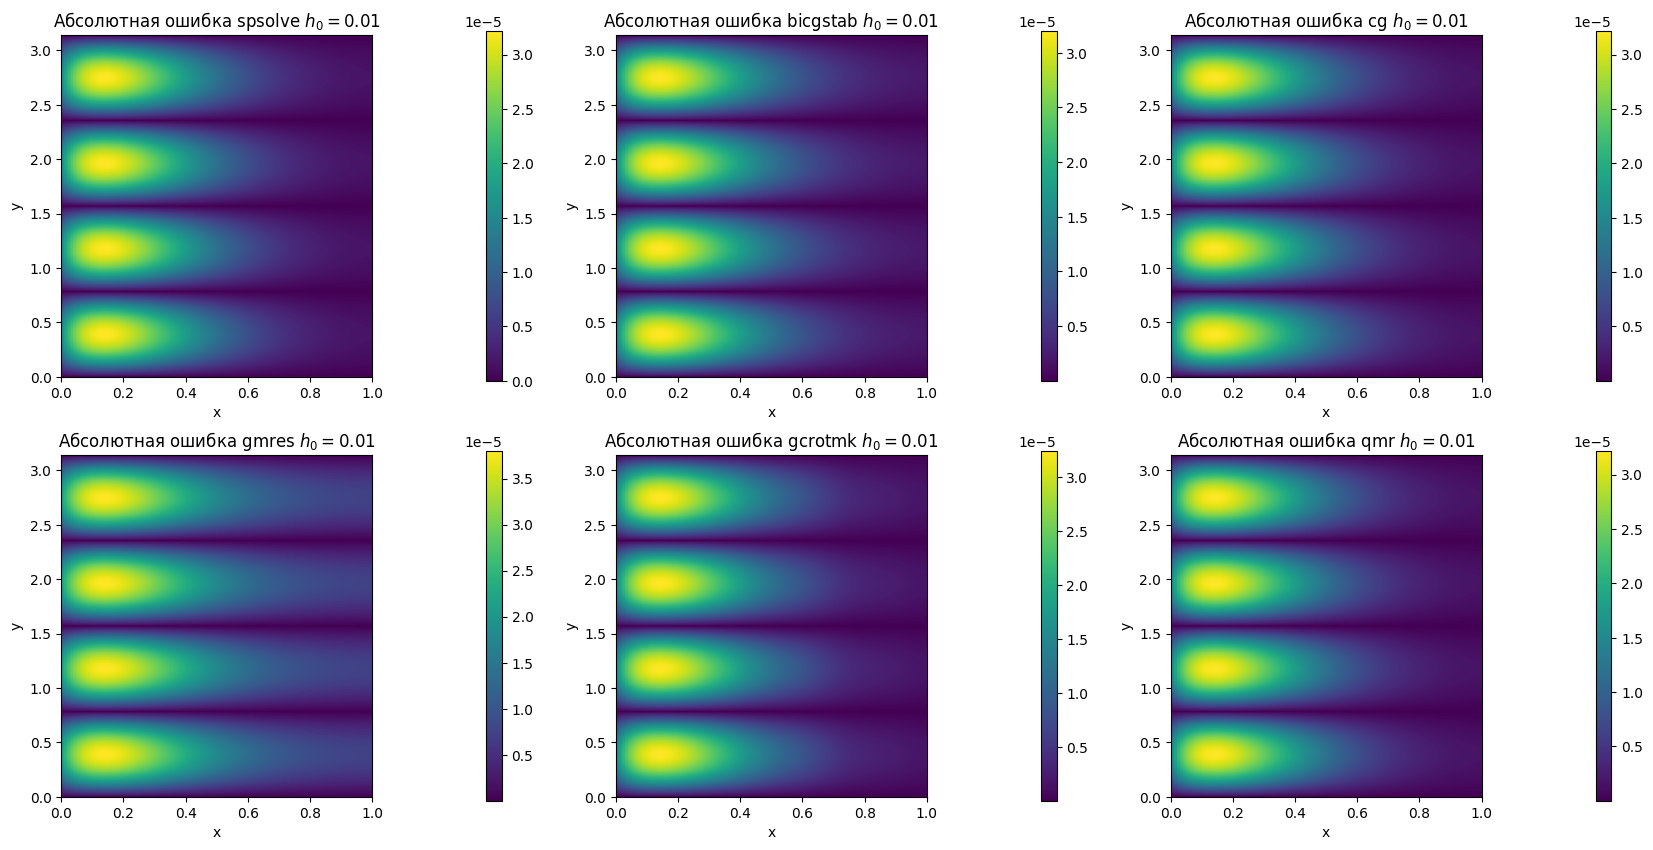

In [33]:
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 6, width_ratios=[1, 0.05, 1, 0.05, 1, 0.05,], wspace=0.7)

ax1 = fig.add_subplot(gs[0])
im1 = ax1.imshow(np.abs((u_sp - analitical(X, Y)).T), origin='lower', extent=(0, l_x, 0, l_y), aspect=0.35)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title(f'Абсолютная ошибка spsolve $h_0 = ${h_0}')

cb1_ax = fig.add_subplot(gs[1])
fig.colorbar(im1, cb1_ax)

ax2 = fig.add_subplot(gs[2])
im2 = ax2.imshow(np.abs((u_bi - analitical(X, Y)).T), origin='lower', extent=(0, l_x, 0, l_y), aspect=0.35)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title(f'Абсолютная ошибка bicgstab $h_0 = ${h_0}')

cb2_ax = fig.add_subplot(gs[3])
fig.colorbar(im2, cb2_ax)

ax3 = fig.add_subplot(gs[4])
im3 = ax3.imshow(np.abs((u_cg - analitical(X, Y)).T), origin='lower', extent=(0, l_x, 0, l_y), aspect=0.35)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_title(f'Абсолютная ошибка cg $h_0 = ${h_0}')

cb3_ax = fig.add_subplot(gs[5])
fig.colorbar(im3, cb3_ax)

ax4 = fig.add_subplot(gs[6])
im4 = ax4.imshow(np.abs((u_gm - analitical(X, Y)).T), origin='lower', extent=(0, l_x, 0, l_y), aspect=0.35)
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_title(f'Абсолютная ошибка gmres $h_0 = ${h_0}')

cb4_ax = fig.add_subplot(gs[7])
fig.colorbar(im4, cb4_ax)

ax5 = fig.add_subplot(gs[8])
im5 = ax5.imshow(np.abs((u_gc - analitical(X, Y)).T), origin='lower', extent=(0, l_x, 0, l_y), aspect=0.35)
ax5.set_xlabel('x')
ax5.set_ylabel('y')
ax5.set_title(f'Абсолютная ошибка gcrotmk $h_0 = ${h_0}')

cb5_ax = fig.add_subplot(gs[9])
fig.colorbar(im5, cb5_ax)

ax6 = fig.add_subplot(gs[10])
im6 = ax6.imshow(np.abs((u_qm - analitical(X, Y)).T), origin='lower', extent=(0, l_x, 0, l_y), aspect=0.35)
ax6.set_xlabel('x')
ax6.set_ylabel('y')
ax6.set_title(f'Абсолютная ошибка qmr $h_0 = ${h_0}')

cb6_ax = fig.add_subplot(gs[11])
fig.colorbar(im6, cb6_ax)

plt.show()

Таким образом все методы дают схожий результат, только gmres выбивается в худшую сторону.

Время, которое потребовалось алгоритмам для рассчета представлено на гистограмме ниже.

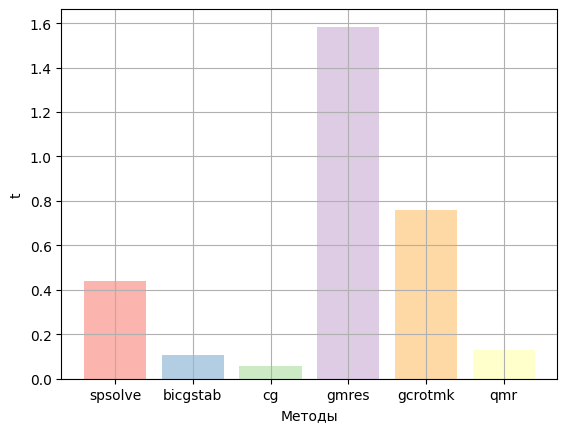

In [34]:
methods = ["spsolve", "bicgstab", "cg", "gmres", "gcrotmk", "qmr"]
times = [time_sp, time_bi, time_cg, time_gm, time_gc, time_qm]
plt.bar(methods, times, color=plt.get_cmap('Pastel1')(np.arange(len(methods))))
plt.xlabel('Методы')
plt.ylabel('t')
plt.grid(True)

plt.show()

Исследуем зависимость ошибки от шага для прямого решателя

In [35]:
steps = [0.05, 0.01, 0.005, 0.003]
errs = []
for h_i in steps:
    n_x, n_y = int(np.round(l_x / h_i)), int(np.round(l_y / h_i))
    h_x, h_y = l_x / n_x, l_y / n_y
    x = np.linspace(h_x / 2, l_x - h_x / 2, n_x)
    y = np.linspace(h_y / 2, l_y - h_y / 2, n_y)
    X, Y = np.meshgrid(x, y, indexing='ij')
    L_i = getL_csr(n_x, n_y, h_x, h_y)
    F = RHS(X, Y, h_x, h_y).flatten()
    u = LA.spsolve(L_i, F).reshape((n_x, n_y))
    u -= u.mean()

    errs.append(np.max(np.abs(u - analitical(X, Y))))

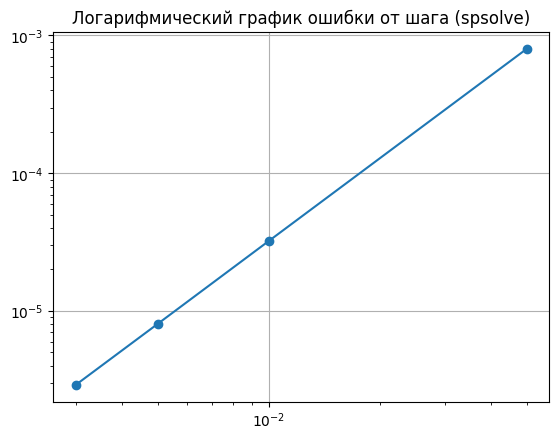

In [36]:
plt.loglog(steps, errs, marker='o')
plt.title("Логарифмический график ошибки от шага (spsolve)")
plt.grid(True)
plt.show()

In [37]:
(np.log(0.0008) - np.log(0.000003)) / (np.log(0.04) - np.log(0.003))

2.156534087879841

Порядок аппроксимации у spsolve по графику 2